In [1]:
import sqlite3
import os
import random
import numpy as np
import cupy as cp
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from scipy import interp
from itertools import cycle
from keras.models import load_model
from tensorflow.keras import models
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, auc

#  Data Processing

In [3]:
gear_defects = [0, 35, 76, 77]

In [ ]:
# Image size
size = [300, 400]

In [3]:
# Load pre-processed dataset
X_train = np.load('gears_train_300x400_0,76,77,35.npy')
X_test = np.load('gears_test_300x400_0,76,77,35.npy')
y_train = np.load('gears_ytrain_300x400_0,76,77,35.npy')
y_test = np.load('gears_ytest_300x400_0,76,77,35.npy')

0.7027792930603027


# Training 

In [6]:
# Set up architecture
dropout = 0.5
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(dropout))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(dropout))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(dropout))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(dropout))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(len(np.unique(y_train))))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 400, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 200, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 200, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 200, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 100, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 100, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 128)      7

In [7]:
# Define early stopping and best model checkpoint
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, min_delta=0.1, patience=40)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1, save_best_only=True)

In [8]:
# Fitting model with early stopping and checkpoint save
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/100
262/262 [==============================] - ETA: 0s - loss: 17.3942 - accuracy: 0.8175
Epoch 00001: val_accuracy improved from -inf to 0.78324, saving model to best_model.h5
262/262 [==============================] - 26s 100ms/step - loss: 17.3942 - accuracy: 0.8175 - val_loss: 0.8317 - val_accuracy: 0.7832
Epoch 2/100
262/262 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.8676
Epoch 00002: val_accuracy did not improve from 0.78324
262/262 [==============================] - 24s 93ms/step - loss: 0.4125 - accuracy: 0.8676 - val_loss: 0.8954 - val_accuracy: 0.7447
Epoch 3/100
262/262 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8922
Epoch 00003: val_accuracy improved from 0.78324 to 0.80347, saving model to best_model.h5
262/262 [==============================] - 25s 97ms/step - loss: 0.3398 - accuracy: 0.8922 - val_loss: 0.8089 - val_accuracy: 0.8035
Epoch 4/100
262/262 [==============================] - ETA: 0s - loss: 0.29

Epoch 28/100
262/262 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9834
Epoch 00028: val_accuracy did not improve from 0.97543
262/262 [==============================] - 24s 91ms/step - loss: 0.0666 - accuracy: 0.9834 - val_loss: 0.1044 - val_accuracy: 0.9677
Epoch 29/100
262/262 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9860
Epoch 00029: val_accuracy did not improve from 0.97543
262/262 [==============================] - 24s 91ms/step - loss: 0.0473 - accuracy: 0.9860 - val_loss: 0.1415 - val_accuracy: 0.9750
Epoch 30/100
262/262 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9893
Epoch 00030: val_accuracy did not improve from 0.97543
262/262 [==============================] - 24s 91ms/step - loss: 0.0340 - accuracy: 0.9893 - val_loss: 0.0911 - val_accuracy: 0.9682
Epoch 31/100
262/262 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9869
Epoch 00031: val_accuracy did not improve fr

In [10]:
model.save('lenet_model.h5')

In [9]:
# Load the best model
model.load_weights('best_model.h5')

In [11]:
# Convert the history.history dict to a pandas DataFrame     
hist_df = pd.DataFrame(history.history) 

# Save to json for plots 
hist_json_file = 'lenet_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# Metrics

In [13]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

65/65 - 2s - loss: 0.1355 - accuracy: 0.9769

Test accuracy: 0.9768785834312439


In [14]:
# Show metrics
predictions = model.predict([X_test])
y_pred = predictions.argmax(axis=1).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       166
           1       0.98      0.89      0.93       198
           2       1.00      0.98      0.99      1558
           3       0.88      1.00      0.93       154

    accuracy                           0.98      2076
   macro avg       0.93      0.97      0.95      2076
weighted avg       0.98      0.98      0.98      2076



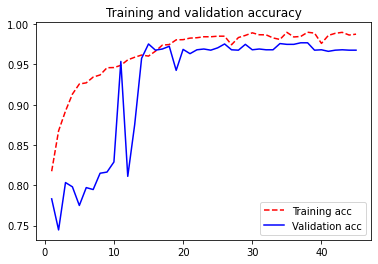

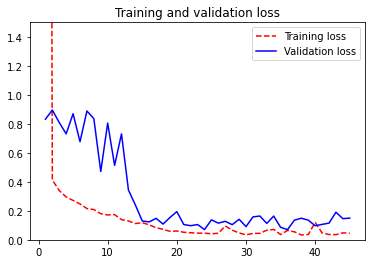

In [15]:
# Plot train and test validation of loss values and accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim([0,1.5])
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [20]:
# ROC binary label reshaping
y_pred_roc = (y_pred[:,None] == np.arange(y_pred.max()+1)).astype(int)
y_test_roc = (y_test[:,None] == np.arange(y_test.max()+1)).astype(int)

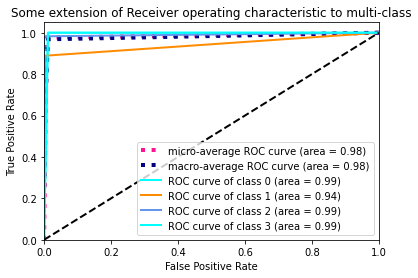

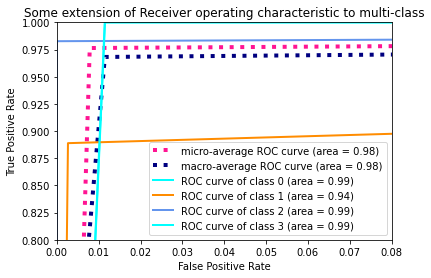

In [21]:
# Plot ROC
def plot_roc(y_test, y_pred):
    # Plot linewidth.
    lw = 2
    n_classes = len(y_pred_roc[0])
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_pred_roc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_pred_roc.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.08)
    plt.ylim(0.8, 1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(y_test_roc,y_pred_roc)

<AxesSubplot:>

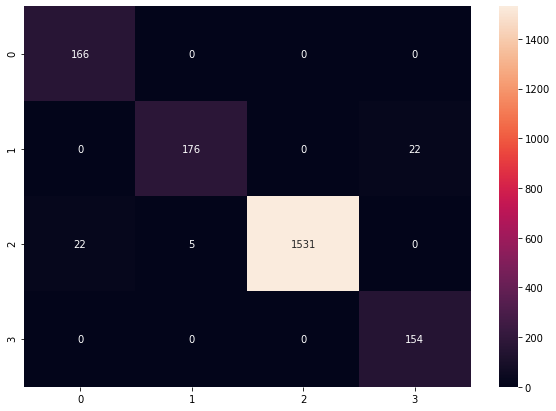

In [22]:
matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in range(len(np.unique(y_test)))],
                  columns = [i for i in range(len(np.unique(y_test)))])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')